In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,balanced_accuracy_score

In [192]:
#! pip install umap-learn

#### Display options

In [3]:
pd.set_option('display.max_row', 25)
pd.set_option('display.max_column', 25)

##### Load the embeddings representations for the ACCP (which is the training dataset) and the HCP dataset (which will be the input for the trained SVM classifier)

In [4]:
#embeddings_ACCP= pd.read_csv("/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Output/2024-05-16/18-00-43_101/ACCP_epoch100_embeddings/full_embeddings.csv")#, index_col=0)
embeddings_ACCP= pd.read_csv("/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Output/2024-05-21/09-50-57_6/ACCP_epoch100_embeddings/full_embeddings.csv")
embeddings_ACCP.head()
embeddings_ACCP.shape

(341, 11)

In [5]:
labels_ACCP = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/subjects_labels.csv")
labels_ACCP = labels_ACCP[['long_name','Left_PCS']]

In [6]:
def encoder(df, col):
    code = {'present':1,
            'absent':0}
    df[col] = df[col].map(code)
    return df

encoder(labels_ACCP,'Left_PCS') 

,long_name,Left_PCS
0,nih_chp_04701_t1,1
1,nih_chp_01534_t1,1
2,nih_chp_04623_t1,1
3,nih_chp_01503_t1,0
4,nih_chp_00404_t1,1
...,...,...
376,a0005_t1_s03,0
377,a0006_t1_s03,1
378,a0001_t1_s03,1
379,a0016_t1_s03,0


In [7]:
#embeddings_HCP = pd.read_csv("/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Output/2024-05-16/18-00-43_101/HCP_epoch100_embeddings/full_embeddings.csv", index_col=0)
embeddings_HCP = pd.read_csv("/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Output/2024-05-21/09-50-57_6/HCP_epoch100_embeddings/full_embeddings.csv", index_col=0)
embeddings_HCP.shape

(1114, 10)

#### Load the UKBiobank embedded space to fit the scaler for the ACCP and HCP data 

In [8]:
#embeddings_UKB = pd.read_csv("/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Output/2024-05-16/18-00-43_101/UKB_epoch100_embeddings/full_embeddings.csv", index_col=0)
embeddings_UKB = pd.read_csv("/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Output/2024-05-21/09-50-57_6/UKB_epoch100_embeddings/full_embeddings.csv", index_col=0)
embeddings_UKB.shape

(21051, 10)

#### Scaler

In [9]:
ebdd_lbl_ACCP = embeddings_ACCP.set_index('ID').join(labels_ACCP.set_index('long_name'))
X = ebdd_lbl_ACCP.drop('Left_PCS', axis=1)
y = ebdd_lbl_ACCP['Left_PCS']

The scaler is fited on the ACCP database at first, it transforms it and then transforms the HCP dataset.
Is it better to fit one everything and transform everything at once ?

In [10]:
scaler = StandardScaler()
scaler.fit(embeddings_UKB)
X = scaler.transform(X)
scl_bdd_hcp = scaler.transform(embeddings_HCP)
X.shape ,scl_bdd_hcp.shape

((341, 10), (1114, 10))

#### SVC model, trained on the ACCP database

In [11]:
model = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

Specific stratification for a more relevant auc.

In [12]:
import os

strat_dic = {}
strat_path = '/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/'

for file in os.listdir(strat_path):
    if file.startswith('ACCpatterns_subjects_train_split'):
        strat_dic[f'train{file[-5:-4]}'] = pd.read_csv(f"{strat_path}{file}")
    if file.startswith('ACCpatterns_subjects_test_split'):
        strat_dic[f'test{file[-5:-4]}'] = pd.read_csv(f"{strat_path}{file}")

X_train = np.array([[]])
X_test = np.array([[]])
y_train = []
y_test = []

for key in strat_dic.keys():
    if key.startswith('train'):
        new_train_lines = ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]].drop('Left_PCS', axis=1).values
        X_train = np.vstack((X_train, new_train_lines)) if X_train.size else new_train_lines
        y_train += ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]]['Left_PCS'].to_list()
    
    if key.startswith('test'):
        new_test_lines = ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]].drop('Left_PCS', axis=1).values
        X_test = np.vstack((X_test, new_test_lines)) if X_test.size else new_test_lines
        y_test += ebdd_lbl_ACCP.loc[strat_dic[key][strat_dic[key].columns[0]]]['Left_PCS'].to_list()

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
model.fit(X_train, y_train)
roc_auc_score(y_test,model.predict_proba(X_test)[:,1]), balanced_accuracy_score(y_test, model.predict(X_test))

/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(0.7609126984126984, 0.6726190476190477)

Cross validation to have another auc (which is supposed to be worse than with the stratification) 

In [13]:
outputs = {}
val_pred = cross_val_predict(model, X, y, cv=5)
auc = roc_auc_score(y, val_pred)
outputs['labels_pred'] = val_pred
outputs['auc'] = auc
outputs['balanced_accuracy_score'] = balanced_accuracy_score(y, val_pred)

In [14]:
outputs['auc'], outputs['balanced_accuracy_score']

(0.6658805031446542, 0.6658805031446541)

he auc value below is not relevant because we are training the model on the whole set so as to test the model on the whole set.

In [15]:
model.fit(X,y)
roc_auc_score(y,model.predict_proba(X)[:,1]), balanced_accuracy_score(y, model.predict(X))

(0.7456303934474184, 0.6736324411291502)

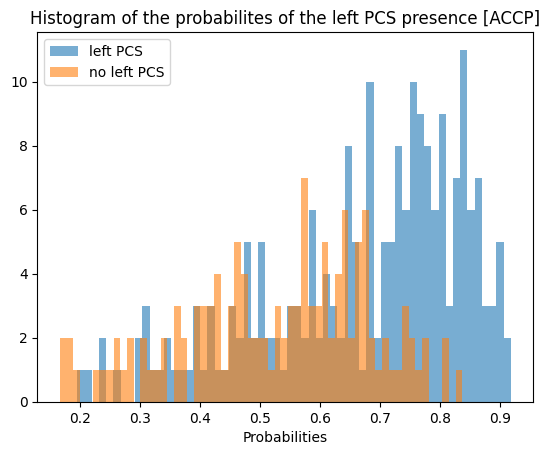

In [16]:
plt.hist(model.predict_proba(X)[y==1,1], bins=60, alpha=0.6, label='left PCS')
plt.hist(model.predict_proba(X)[y==0,1], bins=60, alpha=0.6, label='no left PCS')
plt.xlabel('Probabilities')
plt.title('Histogram of the probabilites of the left PCS presence [ACCP]')
plt.legend()
plt.show()

In [17]:
float((model.predict(X) == (model.predict_proba(X)>0.5)[:,1]).sum())/len(X)

0.8181818181818182

#### Classification of the HCP embeddings

In [18]:
val_pred = model.predict(X=scl_bdd_hcp)

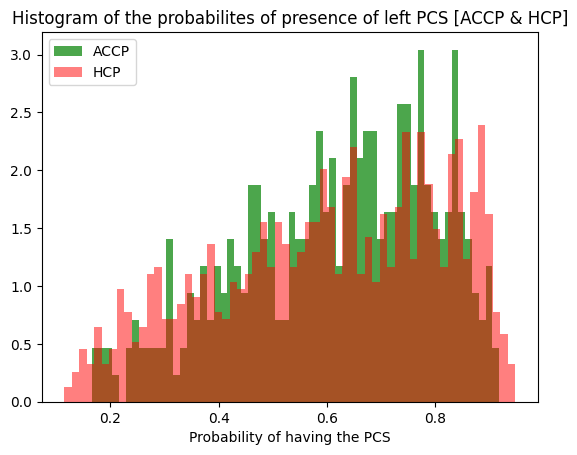

In [19]:
plt.hist(model.predict_proba(X)[:,1], bins=60, color='g', alpha=0.7, label='ACCP', density=True)
plt.hist(model.predict_proba(scl_bdd_hcp)[:,1], bins=60, color='red', alpha=0.5, label='HCP', density=True)
plt.xlabel('Probability of having the PCS')
plt.title('Histogram of the probabilites of presence of left PCS [ACCP & HCP]')
plt.legend()
plt.show()

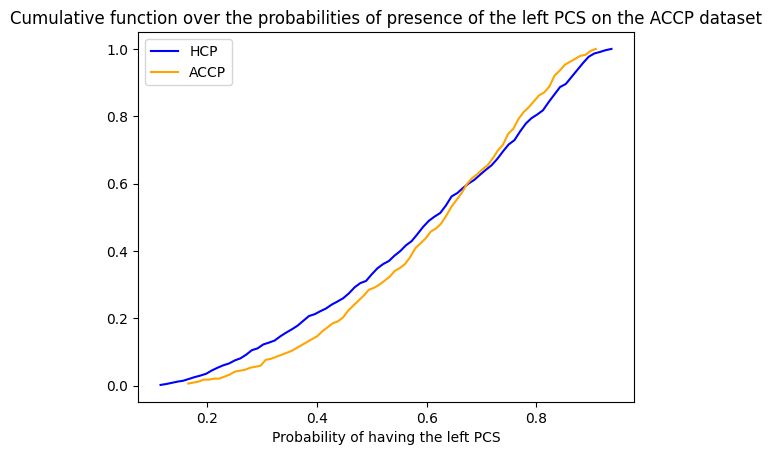

In [20]:
values_ACCP, base_ACCP = np.histogram(model.predict_proba(X)[:,1], bins=80)
cumulative_ACCP = np.cumsum(values_ACCP)
values_HCP, base_HCP = np.histogram(model.predict_proba(scl_bdd_hcp)[:,1], bins=80)
cumulative_HCP = np.cumsum(values_HCP)
# plot the cumulative function
plt.plot(base_HCP[:-1], cumulative_HCP/len(scl_bdd_hcp), c='blue', label='HCP')
#plot the survival function
#plt.plot(base_HCP[:-1], len(model.predict_proba(scl_bdd_hcp)[:,1])-cumulative_HCP, c='green', label = 'survival function')
# plot the cumulative function
plt.plot(base_ACCP[:-1], cumulative_ACCP/len(X), c='orange', label='ACCP')
#plot the survival function
#plt.plot(base_ACCP[:-1], len(model.predict_proba(X)[:,1])-cumulative_ACCP, c='red', label = 'survival function')
plt.xlabel('Probability of having the left PCS')
plt.legend()
plt.title('Cumulative function over the probabilities of presence of the left PCS on the ACCP dataset')
plt.show()

#### SVM classification between ACCP and HCP datasets

In [21]:
scd_bdd_hcp = pd.DataFrame(scl_bdd_hcp, columns=embeddings_HCP.columns)
scd_bdd_hcp['Dataset'] = 0

scd_bdd_ACCP = pd.DataFrame(X,columns=embeddings_HCP.columns)
scd_bdd_ACCP['Dataset'] = 1

scl_bdd_ukb = scaler.transform(embeddings_UKB)
scd_bdd_UKB = pd.DataFrame(scl_bdd_ukb, columns=embeddings_HCP.columns)
scd_bdd_UKB['Dataset'] = 2

In [22]:
scd_bdd_HCP_ACCP = pd.concat([scd_bdd_hcp,scd_bdd_ACCP], axis=0)
scd_bdd_HCP_ACCP_UKB = pd.concat([scd_bdd_HCP_ACCP,scd_bdd_UKB], axis=0)
scd_bdd_HCP_ACCP_UKB

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,Dataset
0,-1.265043,-0.006693,0.717821,0.004881,-0.081962,-1.570848,-1.761905,0.524358,-0.793473,0.088642,0
1,-0.290529,-0.136020,-0.172981,1.060083,-1.309258,-1.554263,-1.762681,-0.066195,-1.427884,-0.951815,0
2,1.815485,-0.610384,-1.636668,0.366764,-1.452142,0.617284,0.188099,-0.477241,-0.400498,-1.566338,0
3,0.726951,-0.849312,0.585935,0.733791,-0.475590,-0.059991,0.442945,1.014628,0.373538,-1.439534,0
4,1.172510,-0.709095,-0.235013,-0.700357,1.059373,-0.214720,-0.046556,-0.658079,-1.233379,0.321727,0
...,...,...,...,...,...,...,...,...,...,...,...
21046,1.780777,-0.230486,-1.684513,-0.194133,-0.328395,1.013742,0.585618,-1.345916,-0.730052,-0.476554,2
21047,0.352262,-0.118158,-1.418345,0.361722,-2.028615,0.906709,-0.115576,0.283272,0.811625,-1.290477,2
21048,0.913569,0.021484,-1.559461,0.856517,-2.095245,-0.095092,-0.744898,-0.653639,-0.802124,-1.356394,2
21049,0.229848,0.349518,-0.294271,1.754575,-1.460099,-0.739622,-0.436278,-0.634353,-1.014730,-0.991815,2


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(scd_bdd_HCP_ACCP.drop("Dataset", axis=1), scd_bdd_HCP_ACCP["Dataset"], test_size=0.01, random_state=40)

In [25]:
model2 = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

In [26]:
model2.fit(X_train,y_train)
val_predict = cross_val_predict(model2, X_train, y_train, cv=10)
auc = roc_auc_score(y_train, val_predict)
auc

0.547945850405288

In [27]:
roc_auc_score(y_test, model2.predict_proba(X_test)[:,1])

0.6818181818181818

### Visualization (UMAP)

In [28]:
import umap

/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
reducer = umap.UMAP()#random_state=5)
scd_bdd_ACCP['Left_PCS'] = y.values
scd_bdd_ACCP['Dataset'] = 'ACCP'
scd_bdd_ACCP['Prediction'] = model.predict(X)
scd_bdd_hcp['Left_PCS'] = -1
scd_bdd_hcp['Dataset'] = 'HCP'
scd_bdd_hcp['Prediction'] = model.predict(scl_bdd_hcp)
scd_bdd_UKB['Left_PCS'] = -1
scd_bdd_UKB['Dataset'] = 'UKB'
scd_bdd_UKB['Prediction'] = model.predict(scl_bdd_ukb)

We fit the reducer only on the UKB database (which is the largest), we concatenate the three bases and reduce them together.

In [31]:
reducer.fit(scd_bdd_UKB.drop(['Left_PCS','Dataset','Prediction'], axis=1))
HCP_and_ACCP = pd.concat([scd_bdd_hcp, scd_bdd_ACCP], axis=0)
HCP_ACCP_UKB = pd.concat([HCP_and_ACCP, scd_bdd_UKB], axis=0)
embedding2D_HCP_ACCP_UKB = reducer.transform(HCP_ACCP_UKB.drop(['Left_PCS','Dataset','Prediction'], axis=1))
embedding2D_HCP_and_ACCP = reducer.transform(HCP_and_ACCP.drop(['Left_PCS','Dataset','Prediction'], axis=1))

This first figure is made to observe the site effect between UKB, ACCP and HCP databases. 

In [32]:
def plot_UMAP(ebb2D_dataset, initial_dataset, title, hue):

    unique_values = initial_dataset[hue].unique()

    if type(initial_dataset[hue].iloc[0])==type("str"):
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[0] if x == 'HCP'\
                          else sns.color_palette()[1] if x == 'ACCP' \
                          else sns.color_palette()[2] for x in initial_dataset['Dataset']]
        s = [8 if x == 'HCP'\
            else 8 if x == 'ACCP' \
            else 0.3 for x in initial_dataset['Dataset']]
    elif -1 in unique_values :
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[x+1] for x in initial_dataset[hue]]
        s = 20
    else :
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[x] for x in initial_dataset[hue]]
        s = 20

    plt.figure(figsize=(12,8))
    plt.scatter(
        ebb2D_dataset[:, 0],
        ebb2D_dataset[:, 1],
        s=s,
        c=dataset_colors)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=12)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=unique_colors[i], markersize=10, 
                                label=f'{unique_values[i]}') 
                    for i in range(len(unique_values))]
    plt.legend(handles=legend_handles, title=hue, loc='best')
    plt.show()

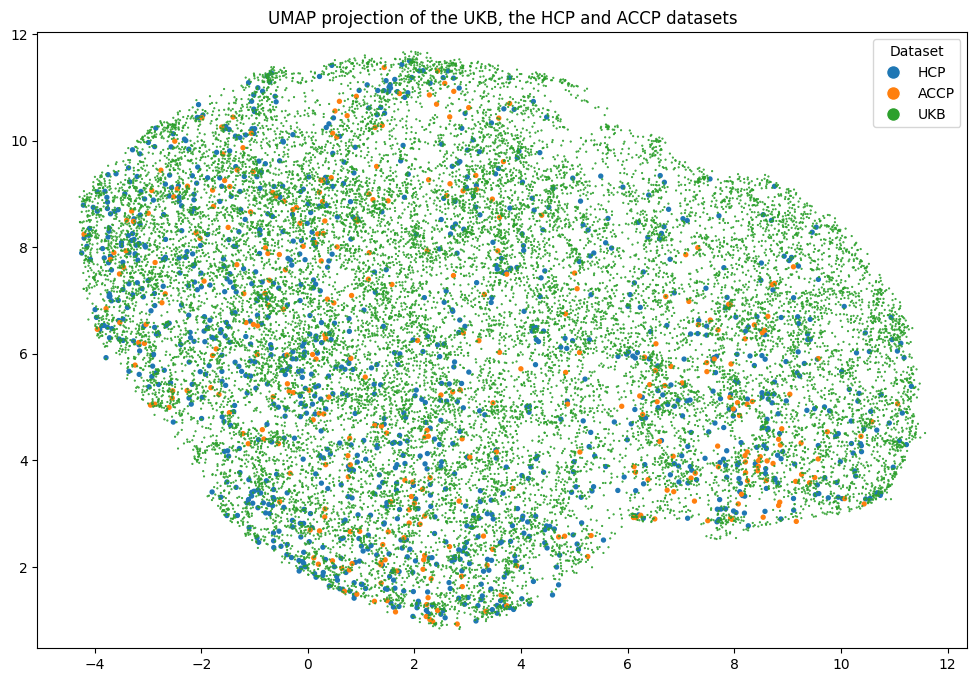

In [33]:
plot_UMAP(embedding2D_HCP_ACCP_UKB, HCP_ACCP_UKB, 'UMAP projection of the UKB, the HCP and ACCP datasets', 'Dataset')

The second figure is made to point out the position of the people having the paracingular (1) (from the ACCP database), those who don't have it (0) (from the ACCP database), and those we don't know (-1) (from the HCP database).

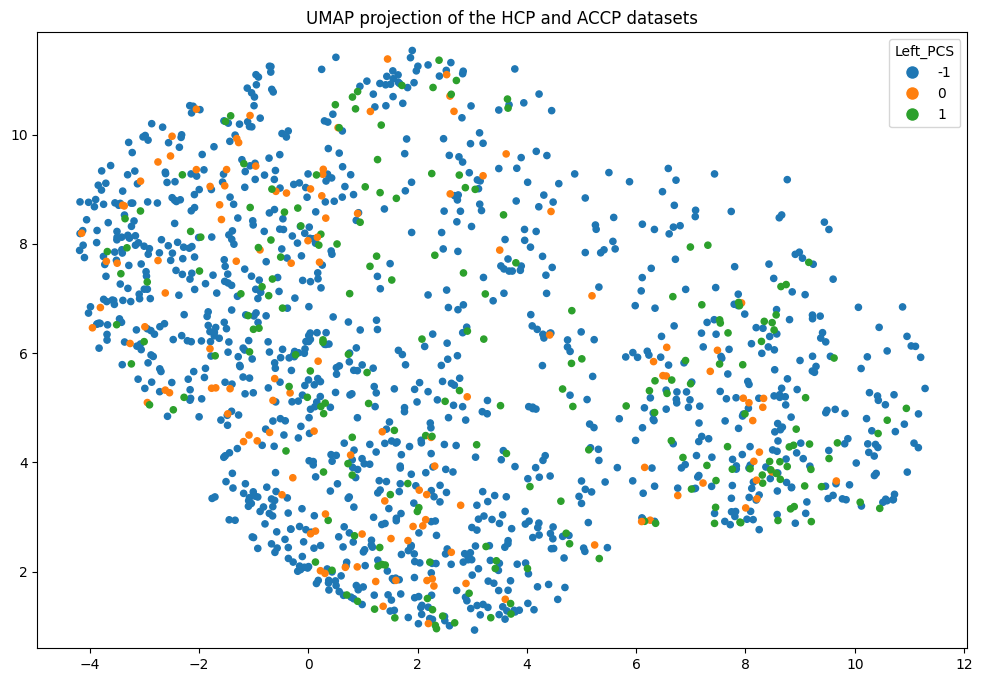

In [34]:
plot_UMAP(embedding2D_HCP_and_ACCP, HCP_and_ACCP, 'UMAP projection of the HCP and ACCP datasets', 'Left_PCS')

Then, the following figure highlights the two classes in the ACCP database.

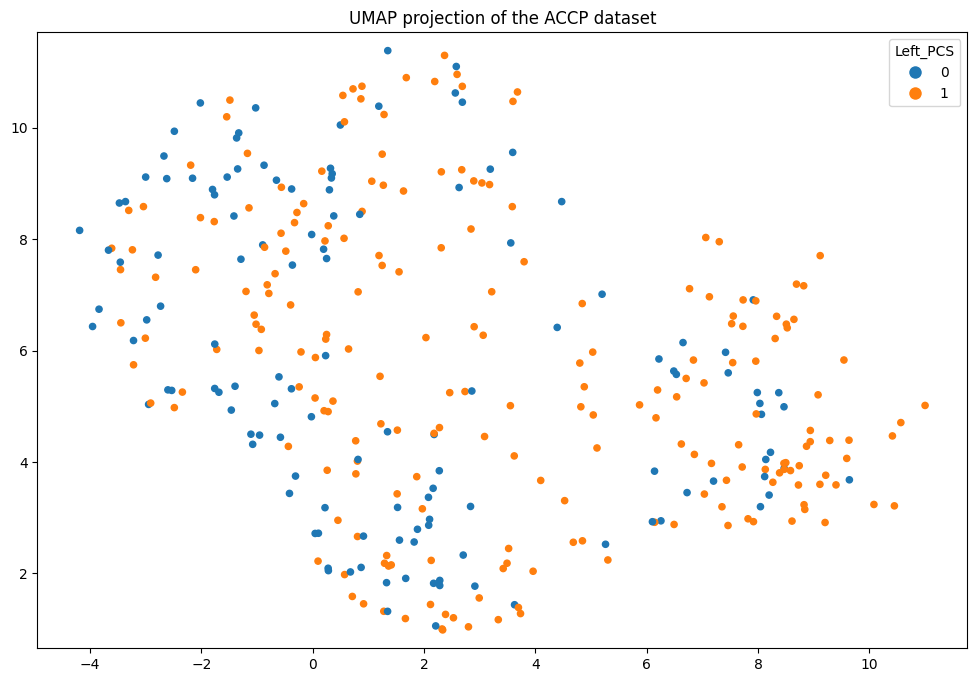

In [35]:
embedding2D_ACCP = reducer.transform(scd_bdd_ACCP.drop(['Left_PCS','Dataset','Prediction'], axis=1))

plot_UMAP(embedding2D_ACCP, scd_bdd_ACCP, 'UMAP projection of the ACCP dataset', 'Left_PCS')

We can do the same one by only keeping the 10 best ranked values given the SVM linear classification, on the ACCP database at first, and on the HCP then.

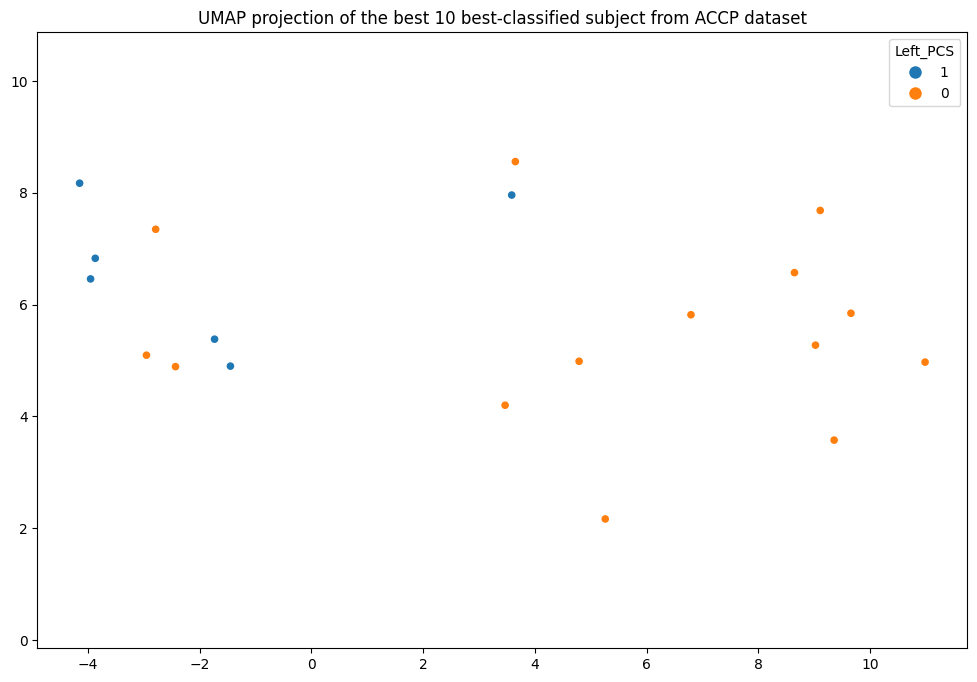

In [36]:
ACCP_proba_pred = model.predict_proba(X)
best_ACCP = pd.concat([scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[-10:]],scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[0:10]]], axis=0)
embedding2D_best_classified_ACCP = reducer.transform(best_ACCP.drop(['Left_PCS','Dataset','Prediction'], axis=1))
plot_UMAP(embedding2D_best_classified_ACCP, best_ACCP, 'UMAP projection of the best 10 best-classified subject from ACCP dataset', 'Left_PCS')

Let's see the SVC borders on the UMAP

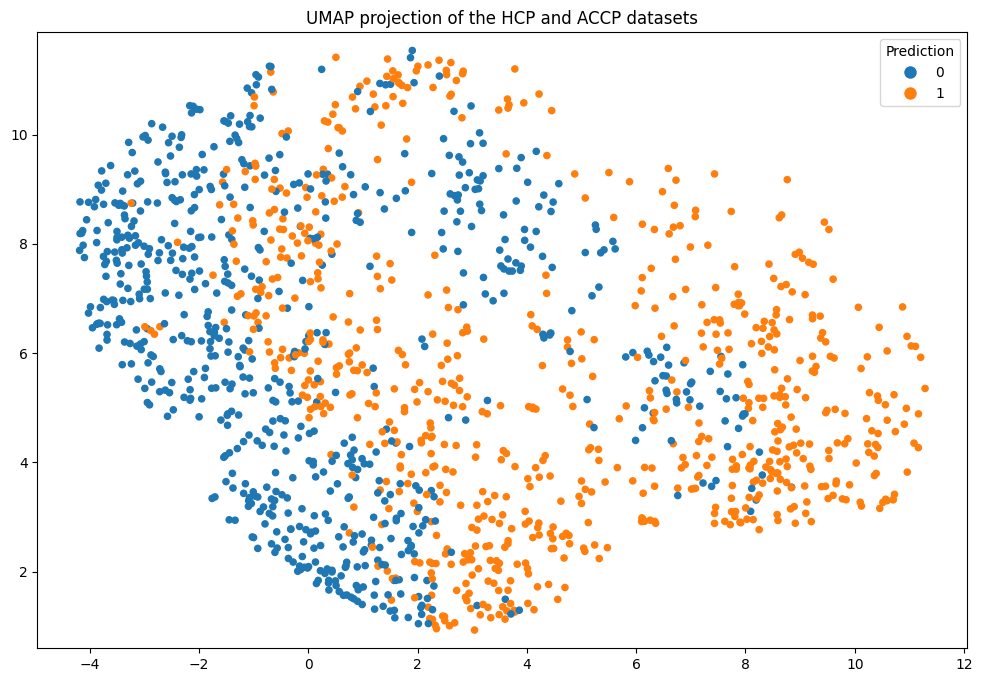

In [37]:
plot_UMAP(embedding2D_HCP_and_ACCP, HCP_and_ACCP, 'UMAP projection of the HCP and ACCP datasets', 'Prediction')

We fit the reducer only on the ACCP database, we concatenate then the two bases and we reduce them together.

In [38]:
reducer.fit(scd_bdd_ACCP.drop(['Left_PCS','Dataset','Prediction'], axis=1))
embedding2D_HCP_and_ACCP = reducer.transform(HCP_and_ACCP.drop(['Left_PCS','Dataset','Prediction'], axis=1))

The first figure is made to observe the site effect between ACCP and HCP databases.

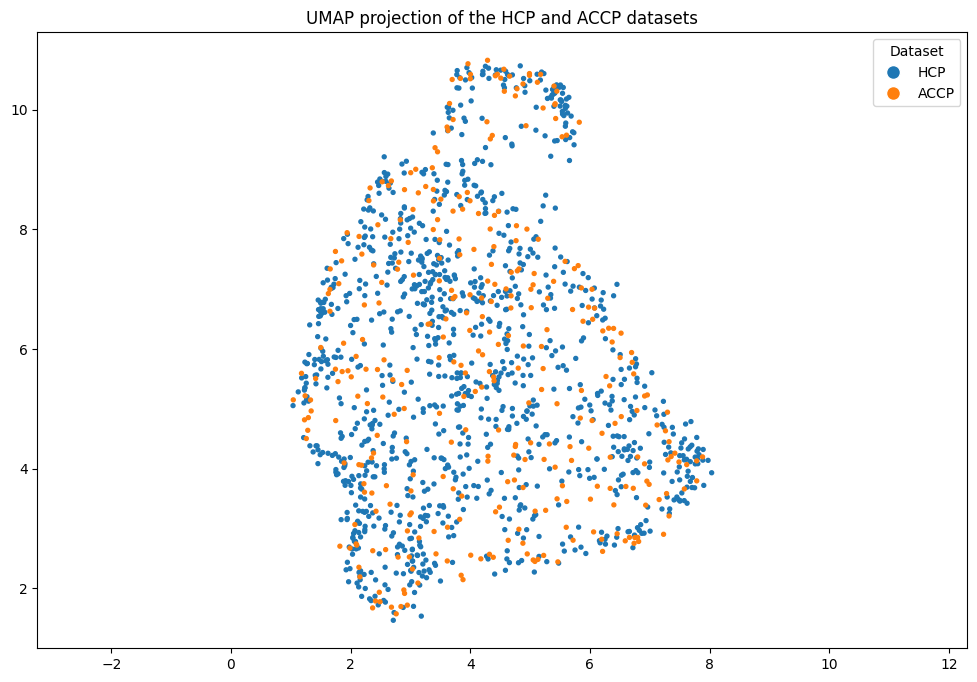

In [39]:
plot_UMAP(embedding2D_HCP_and_ACCP, HCP_and_ACCP, 'UMAP projection of the HCP and ACCP datasets', 'Dataset')

The second figure is made to point out the position of the people having the paracingular (1) (from the ACCP database), those who don't have it (0) (from the ACCP database), and those we don't know (-1) (from the HCP database).

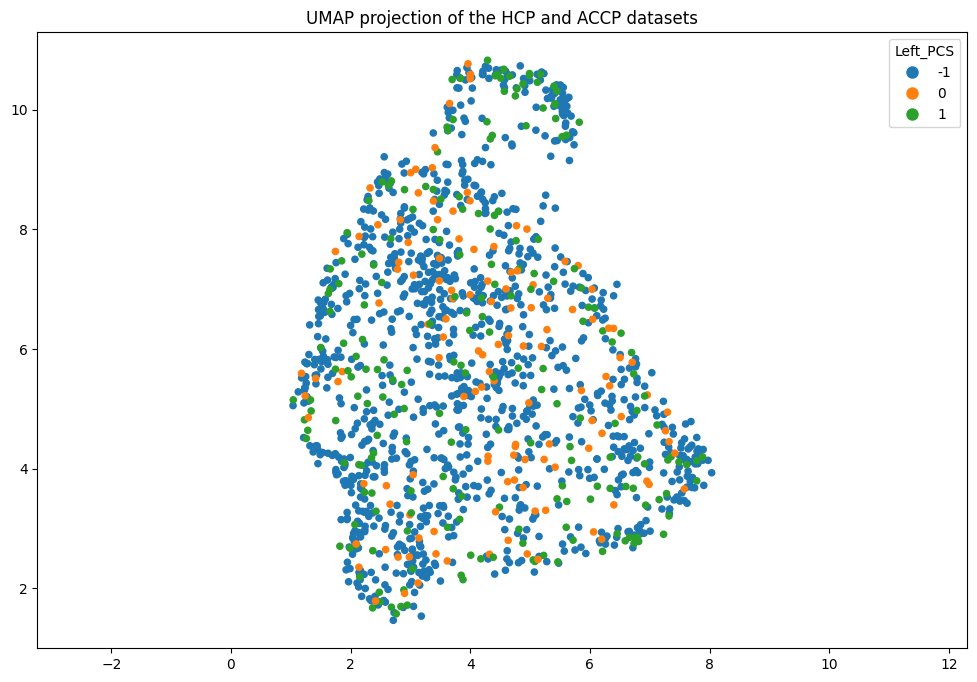

In [40]:
plot_UMAP(embedding2D_HCP_and_ACCP, HCP_and_ACCP, 'UMAP projection of the HCP and ACCP datasets', 'Left_PCS')

Then, the following figure highlights the two classes in the ACCP database.

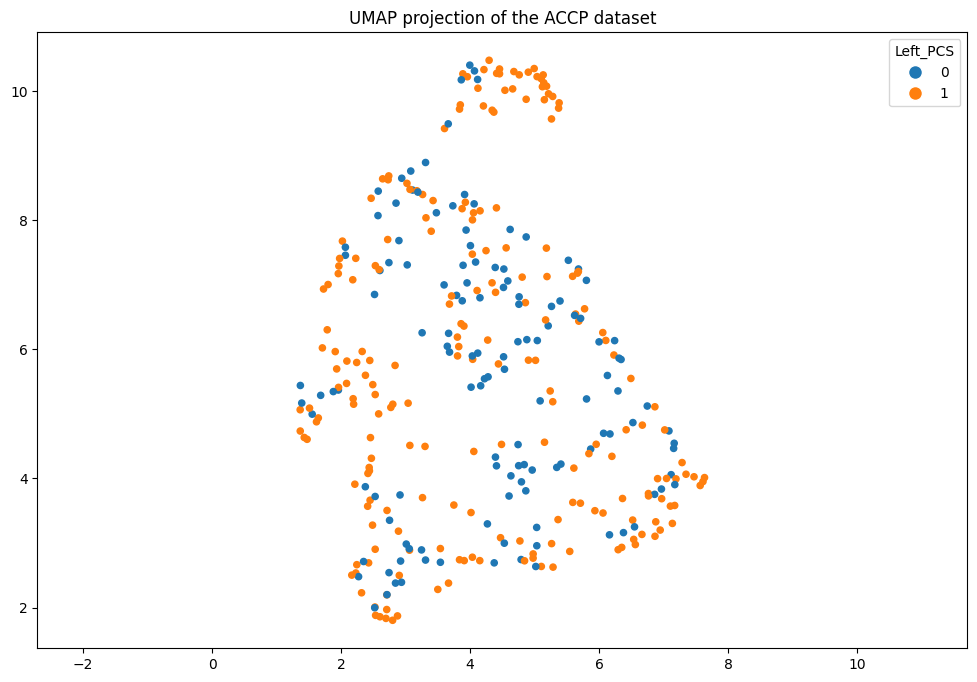

In [41]:
embedding2D_ACCP = reducer.transform(scd_bdd_ACCP.drop(['Left_PCS','Dataset','Prediction'], axis=1))

plot_UMAP(embedding2D_ACCP, scd_bdd_ACCP, 'UMAP projection of the ACCP dataset', 'Left_PCS')

We can do the same one by only keeping the 10 best ranked values given the SVM linear classification, on the ACCP database at first, and on the HCP then.

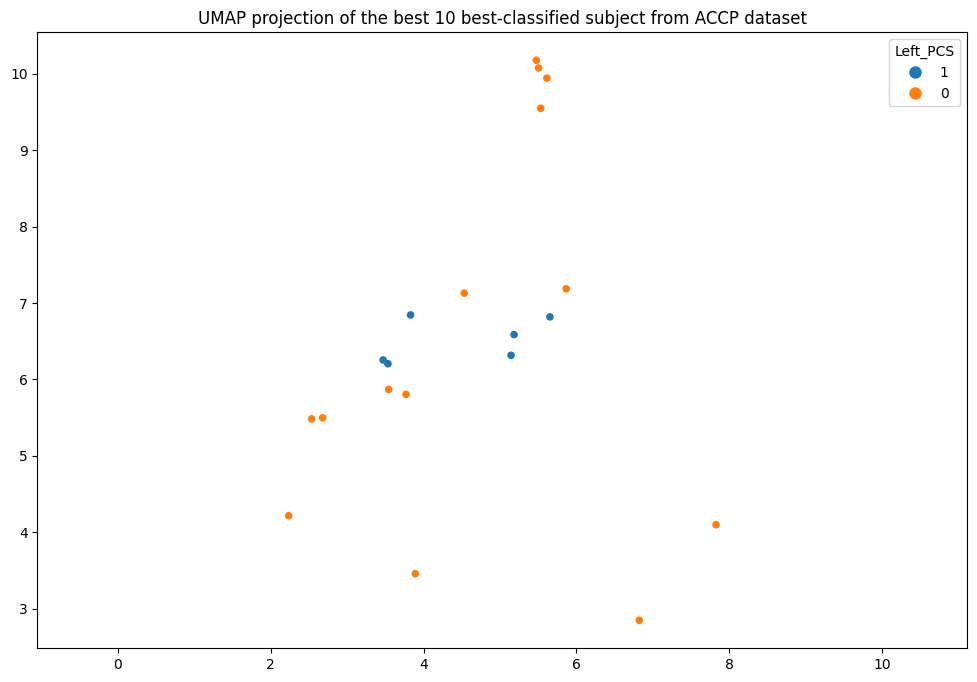

In [42]:
ACCP_proba_pred = model.predict_proba(X)
best_ACCP = pd.concat([scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[-10:]],scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[0:10]]], axis=0)
embedding2D_best_classified_ACCP = reducer.transform(best_ACCP.drop(['Left_PCS','Dataset','Prediction'], axis=1))
plot_UMAP(embedding2D_best_classified_ACCP, best_ACCP, 'UMAP projection of the best 10 best-classified subject from ACCP dataset', 'Left_PCS')

Let's see the SVC borders on the UMAP

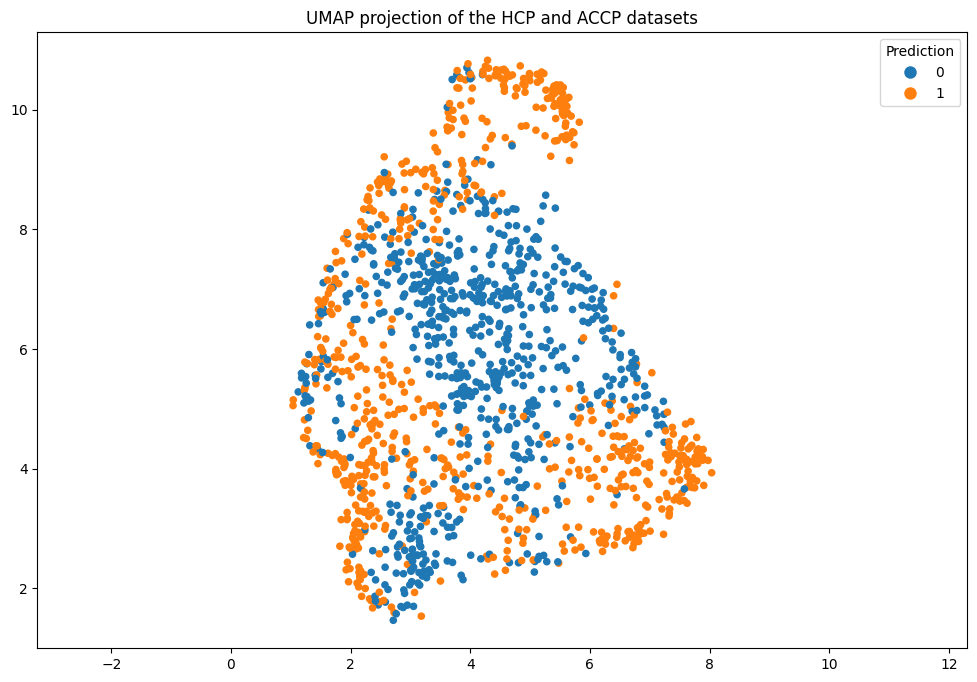

In [43]:
plot_UMAP(embedding2D_HCP_and_ACCP, HCP_and_ACCP, 'UMAP projection of the HCP and ACCP datasets', 'Prediction')

We can get the ID of the best classified subject and see in the Anatomist if the paracingular is there or not.

In [44]:
ACCP_proba_pred = model.predict_proba(scd_bdd_hcp.drop(['Left_PCS', 'Dataset', 'Prediction'], axis=1))
ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[0:5]]

/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


array([[0.05291193, 0.94708807],
       [0.05625144, 0.94374856],
       [0.05957973, 0.94042027],
       [0.06161252, 0.93838748],
       [0.06373169, 0.93626831]])

In [45]:
ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[-5:]]

array([[0.86608057, 0.13391943],
       [0.86635452, 0.13364548],
       [0.86885766, 0.13114234],
       [0.87644816, 0.12355184],
       [0.88479588, 0.11520412]])

In [46]:
embeddings_HCP.iloc[ACCP_proba_pred[:,0].argsort()[1114//2-2:1114//2+2]].index

Index([172130, 283543, 130619, 908860], dtype='int64', name='ID')

First 5 people predicted without paracingulate sulcus.

In [47]:
embeddings_HCP.iloc[ACCP_proba_pred[:,0].argsort()[-5:]].index

Index([745555, 205725, 212823, 828862, 203923], dtype='int64', name='ID')

First 5 people predicted with paracingulate sulcus.

In [48]:
embeddings_HCP.iloc[ACCP_proba_pred[:,0].argsort()[0:5]].index

Index([962058, 779370, 421226, 187143, 210112], dtype='int64', name='ID')

### CSV file generation for SOLAR

In [49]:
df_HCP_binary_pred_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Pred" : model.predict(X=scl_bdd_hcp)})

df_HCP_binary_pred_PCS.to_csv('/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Heritability/data/HCP_binary_pred_left_PCS_2.csv', index=False)
df_HCP_binary_pred_PCS.sort_values('IID')

,IID,Pred
0,100206,0
1,100307,1
2,100408,1
3,100610,1
4,101006,0
...,...,...
1109,992774,0
1110,993675,0
1111,994273,0
1112,995174,0


In [50]:
df_HCP_prob_pred_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Pred" : model.predict_proba(scl_bdd_hcp)[:,1]})

df_HCP_prob_pred_PCS.to_csv('/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Heritability/data/HCP_prob_pred_left_PCS_2.csv', index=False)
df_HCP_prob_pred_PCS

,IID,Pred
0,100206,0.542780
1,100307,0.629808
2,100408,0.691219
3,100610,0.644955
4,101006,0.354479
...,...,...
1109,992774,0.500000
1110,993675,0.349324
1111,994273,0.592022
1112,995174,0.480805


### To compare the prediction obtained from different embeddings models (dim10)

In [51]:
left_PCS_pred2_dim10 = pd.read_csv('/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Heritability/data/HCP_prob_pred_left_PCS_2.csv')
left_PCS_pred_dim10 = pd.read_csv('/neurospin/dico/adufournet/Runs/05_Heritability_Left_PCS_HCP_dim10/Heritability/data/HCP_prob_pred_left_PCS.csv')
LeftPCS = pd.merge(left_PCS_pred_dim10, left_PCS_pred2_dim10, how='inner', on='IID', suffixes=[101,102])
LeftPCS.drop('IID', axis=1).corr()

,Pred101,Pred102
Pred101,1.000000,0.753321
Pred102,0.753321,1.000000


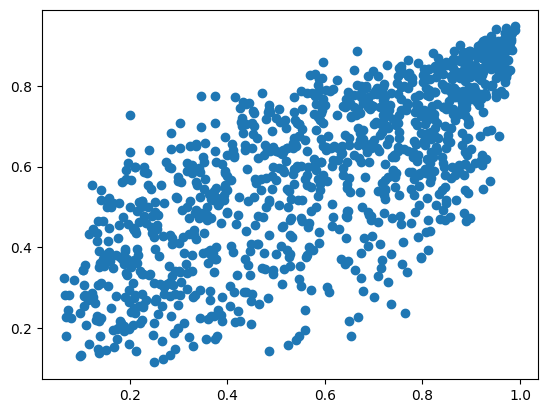

In [52]:
plt.scatter(LeftPCS['Pred101'], LeftPCS['Pred102'])
plt.show()